## import necessary libraries

In [1]:
! pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, f1_score, precision_score, recall_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, roc_curve, auc

2024-05-07 10:53:04.679808: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 10:53:05.239442: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [102]:
file_paths = ['CAD and exercise.csv', 'CAD and exercise1.csv', 'CAD and exercise2.csv',
              'CTG Alzeimers disease and exercise.csv', 'CTG Alzheimer disease and physical activity.csv',
              'CTG Alzheimer disease.csv', 'CTG CAD and phycial activity.csv', 'CTG Cardiac and exercise.csv',
              'CTG Cardio and exercise.csv', 'CTG Cardio and physical activity.csv',
              'CTG Cardiovascular disease and exercise.csv', 'CTG Cardiovascular disease and physical activity.csv',
              'CTG Chronic kidney disease and exercise.csv', 'CTG Chronic kidney disease and physical activity.csv',
              'CTG Diabetes and exercise.csv', 'CTG Diabetes and physical activity.csv',
              'CTG Diabetes mellitus and exercise.csv', 'CTG Diabetes mellitus type 2 and exercise.csv',
              'CTG Diabetes mellitus type 2 and physical activity.csv', 'CTG Kneeosteoarthritis and exercise.csv',
              'CTG Kneeosteoarthritis and physical activity.csv', 'CTG Obesity and exercise.csv',
              'CTG Obesity and physical activity.csv', 'CTG Osteoarthritis and exercise.csv',
              'CTG Osteoarthritis and physical activity.csv', 'CTG PAD and exercise 1.csv',
              'CTG PAD and exercise.csv', 'CTG PAD and physical activity.csv', 'CTG PAD and physical activity1.csv',
              'CTG Physical activity and CAD.csv', 'CTG heart and exercise.csv', 'CTG stroke and exercise.csv',
              'CTG stroke and exercise1.csv', 'CTG stroke and physical activity.csv',
              'CTG stroke and physical activity1.csv', 'CTG studies diabetes and physical activity.csv']

In [103]:
clinical_trial_dataframes = [pd.read_csv(file) for file in file_paths]

ct_data= pd.concat(clinical_trial_dataframes, ignore_index=True)

## Extracting Exercise-Related Data

In [104]:
# Filter rows containing exercise-related interventions
exercise_data = ct_data[ct_data['Interventions'].str.contains('Exercise', case=False, na=False)]

## Data Loading and Preprocessing

In [105]:
def preprocess_data(data):
    data_copy = data.copy()
    # Handle missing values
    data_copy.dropna(subset=['Conditions', 'Interventions'], inplace=True)
    # Drop irrelevant columns
    columns_to_drop = ['Study Title', 'Study URL', 'Acronym', 'Study Status', 'Brief Summary', 'Study Results',
                       'Sponsor', 'Collaborators', 'Phases', 'Funder Type', 'Study Type', 'Study Design',
                       'Start Date', 'Primary Completion Date', 'Completion Date', 'First Posted', 'Results First Posted',
                       'Last Update Posted', 'Locations', 'Study Documents']
    data_copy.drop(columns=columns_to_drop, inplace=True)
    return data_copy

preprocessed_data = preprocess_data(exercise_data)
preprocessed_data


,NCT Number,Conditions,Interventions,Primary Outcome Measures,Secondary Outcome Measures,Other Outcome Measures,Sex,Age,Enrollment,Other IDs,Total number of studies,1158,Unnamed: 2,Unnamed: 3,Type Intervention,Unnamed: 5,Total number of patients
0,NCT03534427,Prehypertension|Blood Pressure|Abdominal Obesi...,OTHER: Jump rope exercise intervention,"Arterial Stiffness, Arterial stiffness was mea...",NaN,NaN,FEMALE,CHILD,40.0,PusanNU1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NCT04009629,Alzheimer Disease 2 Due to Apoe4 Isoform|Healt...,BEHAVIORAL: Moderate Intensity Aerobic Exercise,"Cerebral Blood Flow Area Under Curve, Cumulati...","Insulin-like Growth Factor-1 Change, Change in...",NaN,ALL,OLDER_ADULT,61.0,STUDY00142822|R21AG061548,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NCT03448185,"Obesity|Heart Failure, Diastolic|Metabolic Syn...",BEHAVIORAL: High intensity exercise|DIETARY_SU...,Change From Baseline at 1 Year in Myocardial L...,Change From Baseline at 1 Year in Peak Volume ...,NaN,ALL,ADULT,80.0,STU 062014-067,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NCT01109992,Coronary Artery Disease,DRUG: Exercise plus Regadenoson (Lexercise)|DR...,Safety and Tolerability of Combined Exercise a...,"Image Quality: Heart to Liver Ratio of Counts,...",NaN,ALL,"ADULT, OLDER_ADULT",43.0,BWH,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NCT03197038,"Cognitive Function, Preclinical|Chronic Kidney...",BEHAVIORAL: Partially supervised home-based wa...,"Composite Global Cognitive Function, Determine...","White Matter Integrity, Whole brain white matt...",NaN,ALL,"ADULT, OLDER_ADULT",39.0,2016-1217|P30AG022849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,NCT03370471,Aging|Aphasia,BEHAVIORAL: Retrieval Practice + Moderate Inte...,"Study-Specific Word Recall Task, Study-specifi...","Serum BDNF Concentration Levels (pg/mL), Blood...",NaN,ALL,"ADULT, OLDER_ADULT",28.0,C2238-P,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1040,NCT05115149,Stroke|Spinal Cord Injuries,DEVICE: VIBRAINT RehUp robotic orthosis|PROCED...,Change from Baseline Fugl-Meyer scale for the ...,Change from Baseline Accuracy of BCI tasks aft...,NaN,ALL,ADULT,60.0,Skoltech-CNBR1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1041,NCT03370471,Aging|Aphasia,BEHAVIORAL: Retrieval Practice + Moderate Inte...,"Study-Specific Word Recall Task, Study-specifi...","Serum BDNF Concentration Levels (pg/mL), Blood...",NaN,ALL,"ADULT, OLDER_ADULT",28.0,C2238-P,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1061,NCT05115149,Stroke|Spinal Cord Injuries,DEVICE: VIBRAINT RehUp robotic orthosis|PROCED...,Change from Baseline Fugl-Meyer scale for the ...,Change from Baseline Accuracy of BCI tasks aft...,NaN,ALL,ADULT,60.0,Skoltech-CNBR1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Feature Engineering

We apply TF-TDF (Term Frequency-Inverse Document Frequency) vectorization to the text data in the 'Interventions' and 'Conditions' columns. This technique transforms the text into numerical features based on the frequency and importance of the words across the dataset. These TF-TDF features will then be combined with the existing numeric features ('Age','Sex','Enrollment') to create more informative feature matrix.

The feature matrix now includes additional features derived from text data, which may potentially capture relevant information for clustering and classification

In [106]:
def engineer_features(data):
    # Perform feature engineering
    conditions_split = data['Conditions'].str.split('|', expand=True)
    conditions_split.columns = [f'Condition_{i}' for i in range(1, conditions_split.shape[1] + 1)]
    conditions_encoded = pd.get_dummies(conditions_split, prefix='Condition')

    intervention_types = data['Interventions'].str.split(':', n=1, expand=True)[0]
    intervention_types_encoded = pd.get_dummies(intervention_types, prefix='Intervention')

    sex_encoded = pd.get_dummies(data['Sex'], prefix='Sex')
    age_encoded = pd.get_dummies(data['Age'], prefix='Age')

    # Apply TF-IDF vectorization to 'Conditions' and 'Interventions' columns
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_matrix_conditions = tfidf_vectorizer.fit_transform(data['Conditions'])
    tfidf_matrix_interventions = tfidf_vectorizer.fit_transform(data['Interventions'])

    # Convert sparse matrices to dense arrays
    tfidf_features_conditions = tfidf_matrix_conditions.toarray()
    tfidf_features_interventions = tfidf_matrix_interventions.toarray()

    # Combine the TF-IDF features with the existing numeric features
    exercise_features = pd.concat([conditions_encoded, intervention_types_encoded, sex_encoded, age_encoded,
                                    pd.DataFrame(tfidf_features_conditions), pd.DataFrame(tfidf_features_interventions)], axis=1)

    return data, exercise_features

In [107]:
exercise_data, exercise_features = engineer_features(preprocessed_data)

## Data Merging and Temporary Target Variable Creation

In [108]:
# Merge exercise_features and exercise_data based on index
merged_data = pd.concat([exercise_data.reset_index(drop=True), exercise_features.reset_index(drop=True)], axis=1)

# Create a temporary target variable based on a feature or combination of features
temp_target = exercise_data['Age'] + exercise_data['Sex']

# Convert the temporary target variable to categorical labels
temp_target = pd.Categorical(temp_target).codes


In [109]:
# Convert all column names to strings
exercise_features.columns = exercise_features.columns.astype(str)

## Oversampling

In [110]:
# Oversampling with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, _ = ros.fit_resample(exercise_features, temp_target)

In [111]:
# Identify rows with missing values
missing_mask = X_resampled.isna().any(axis=1)

# Remove rows with missing values
X_resampled_no_missing = X_resampled[~missing_mask]

## Clustering

In [112]:
#Evaluate and Optimize Clustering Techniques
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    score = silhouette_score(X, labels)
    return score

# Define the parameter grids for different clustering algorithms
kmeans_params = {
    'n_clusters': [2, 3, 4, 5],
    'init': ['k-means++', 'random']
}

hierarchical_params = {
    'n_clusters': [2, 3, 4, 5],
    'linkage': ['ward', 'complete', 'average']
}

dbscan_params = {
    'eps': np.arange(0.1, 1.0, 0.1),
    'min_samples': [2, 3, 4, 5]
}

# Evaluate KMeans
best_kmeans_score = -1
best_kmeans_params = None

for n_clusters in kmeans_params['n_clusters']:
    for init in kmeans_params['init']:
        kmeans = KMeans(n_clusters=n_clusters, init=init)
        score = silhouette_scorer(kmeans, X_resampled_no_missing)
        if score > best_kmeans_score:
            best_kmeans_score = score
            best_kmeans_params = {'n_clusters': n_clusters, 'init': init}

print("Best KMeans hyperparameters:", best_kmeans_params)
print("Best KMeans Silhouette Score:", best_kmeans_score)

# Evaluate Hierarchical Clustering
best_hierarchical_score = -1
best_hierarchical_params = None

for n_clusters in hierarchical_params['n_clusters']:
    for linkage in hierarchical_params['linkage']:
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        score = silhouette_scorer(hierarchical, X_resampled_no_missing)
        if score > best_hierarchical_score:
            best_hierarchical_score = score
            best_hierarchical_params = {'n_clusters': n_clusters, 'linkage': linkage}

print("\nBest Hierarchical hyperparameters:", best_hierarchical_params)
print("Best Hierarchical Silhouette Score:", best_hierarchical_score)

# Evaluate DBSCAN
best_dbscan_score = -1
best_dbscan_params = None

for eps in dbscan_params['eps']:
    for min_samples in dbscan_params['min_samples']:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        score = silhouette_scorer(dbscan, X_resampled_no_missing)
        if score > best_dbscan_score:
            best_dbscan_score = score
            best_dbscan_params = {'eps': eps, 'min_samples': min_samples}

print("\nBest DBSCAN hyperparameters:", best_dbscan_params)
print("Best DBSCAN Silhouette Score:", best_dbscan_score)

Best KMeans hyperparameters: {'n_clusters': 5, 'init': 'k-means++'}
Best KMeans Silhouette Score: 0.5201039519017001

Best Hierarchical hyperparameters: {'n_clusters': 5, 'linkage': 'ward'}
Best Hierarchical Silhouette Score: 0.5209113031314324

Best DBSCAN hyperparameters: {'eps': 0.1, 'min_samples': 2}
Best DBSCAN Silhouette Score: 0.8860899681864207


In [113]:
def perform_clustering(data, best_kmeans_params, best_hierarchical_params, best_dbscan_params):
    # KMeans clustering with best parameters
    best_kmeans = KMeans(n_clusters=best_kmeans_params['n_clusters'], init=best_kmeans_params['init'], random_state=42)
    kmeans_labels = best_kmeans.fit_predict(data)
    silhouette_kmeans = silhouette_score(data, kmeans_labels)
    num_kmeans_clusters = best_kmeans_params['n_clusters']
    print(f"KMeans Silhouette Score: {silhouette_kmeans:.3f}")
    print(f"Number of KMeans clusters: {num_kmeans_clusters}")

    # Hierarchical clustering with best parameters
    best_hierarchical = AgglomerativeClustering(n_clusters=best_hierarchical_params['n_clusters'], linkage=best_hierarchical_params['linkage'])
    hierarchical_labels = best_hierarchical.fit_predict(data)
    silhouette_hierarchical = silhouette_score(data, hierarchical_labels)
    num_hierarchical_clusters = best_hierarchical_params['n_clusters']
    print(f"Hierarchical Silhouette Score: {silhouette_hierarchical:.3f}")
    print(f"Number of Hierarchical clusters: {num_hierarchical_clusters}")

    # DBSCAN clustering with best parameters
    best_dbscan = DBSCAN(eps=best_dbscan_params['eps'], min_samples=best_dbscan_params['min_samples'])
    dbscan_labels = best_dbscan.fit_predict(data)
    silhouette_dbscan = silhouette_score(data, dbscan_labels)
    num_dbscan_clusters = len(np.unique(dbscan_labels[dbscan_labels != -1]))
    print(f"DBSCAN Silhouette Score: {silhouette_dbscan:.3f}")
    print(f"Number of DBSCAN clusters: {num_dbscan_clusters}")

    # Create a new DataFrame with the oversampled data and cluster labels
    resampled_data = pd.DataFrame(data, columns=exercise_features.columns)
    resampled_data['KMeans_Cluster'] = kmeans_labels
    resampled_data['Hierarchical_Cluster'] = hierarchical_labels
    resampled_data['DBSCAN_Cluster'] = dbscan_labels

    # Merge resampled_data with necessary columns from merged_data
    resampled_data = pd.concat([resampled_data, merged_data[['Conditions', 'Interventions', 'Age', 'Sex']]], axis=1)

    return resampled_data

In [114]:
resampled_data = perform_clustering(X_resampled_no_missing, best_kmeans_params, best_hierarchical_params, best_dbscan_params)

KMeans Silhouette Score: 0.447
Number of KMeans clusters: 5
Hierarchical Silhouette Score: 0.521
Number of Hierarchical clusters: 5
DBSCAN Silhouette Score: 0.886
Number of DBSCAN clusters: 17


/tmp/ipykernel_42921/401926599.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled_data['KMeans_Cluster'] = kmeans_labels
/tmp/ipykernel_42921/401926599.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled_data['Hierarchical_Cluster'] = hierarchical_labels
/tmp/ipykernel_42921/401926599.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

The Silhouette score measures how well each data point fits into its assigned cluster, with values ranging from -1 to 1. A higher Silhouette score indicates better-defined clusters, where data points are well-matched to their own cluster and poorly-matched to neighboring clusters. The Silhouette Visualizer can be used to determine the optimal number of clusters by plotting the average Silhouette score for different values of k, and identifying the value of k with the highest score. The Silhouette method is considered more reliable than the Elbow method, especially when the elbow point is not clearly defined.

/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/yellowbrick/style/colors.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(colormap)


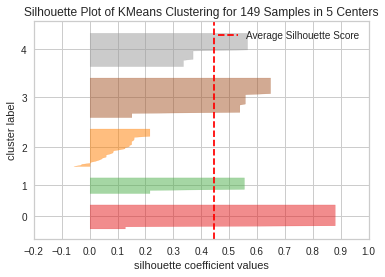

/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/yellowbrick/style/colors.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(colormap)


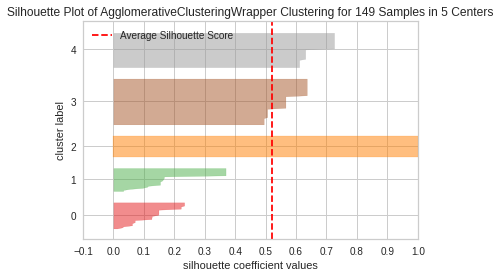

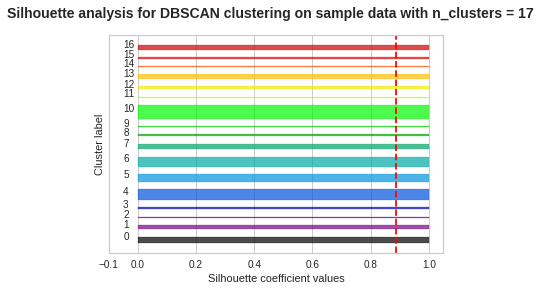

In [119]:
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.base import BaseEstimator, ClusterMixin

class AgglomerativeClusteringWrapper(BaseEstimator, ClusterMixin):
    def __init__(self, model):
        self.model = model
        self.n_clusters = model.n_clusters
    
    def fit(self, X, y=None):
        self.labels_ = self.model.fit_predict(X)
        return self
    
    def predict(self, X):
        return self.labels_

# Visualize silhouette plots for KMeans
visualizer_kmeans = SilhouetteVisualizer(KMeans(n_clusters=best_kmeans_params['n_clusters'], init=best_kmeans_params['init'], random_state=42))
visualizer_kmeans.fit(X_resampled_no_missing)
visualizer_kmeans.show()

# Visualize silhouette plots for Hierarchical Clustering
hierarchical_model = AgglomerativeClustering(n_clusters=best_hierarchical_params['n_clusters'], linkage=best_hierarchical_params['linkage'])
hierarchical_wrapper = AgglomerativeClusteringWrapper(hierarchical_model)

visualizer_hierarchical = SilhouetteVisualizer(hierarchical_wrapper)
visualizer_hierarchical.fit(X_resampled_no_missing)
visualizer_hierarchical.show()

# Visualize silhouette plot for DBSCAN
dbscan_model = DBSCAN(eps=best_dbscan_params['eps'], min_samples=best_dbscan_params['min_samples'])
dbscan_labels = dbscan_model.fit_predict(X_resampled_no_missing)

# Compute silhouette scores for DBSCAN
silhouette_avg = silhouette_score(X_resampled_no_missing, dbscan_labels)
sample_silhouette_values = silhouette_samples(X_resampled_no_missing, dbscan_labels)

# Plot the silhouette plot for DBSCAN
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
fig, ax = plt.subplots()
y_lower = 10

for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[dbscan_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")

ax.axvline(x=silhouette_avg, color="red", linestyle="--")

ax.set_yticks([])
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(f"Silhouette analysis for DBSCAN clustering on sample data with n_clusters = {n_clusters}",
              fontsize=14, fontweight='bold')

plt.show()

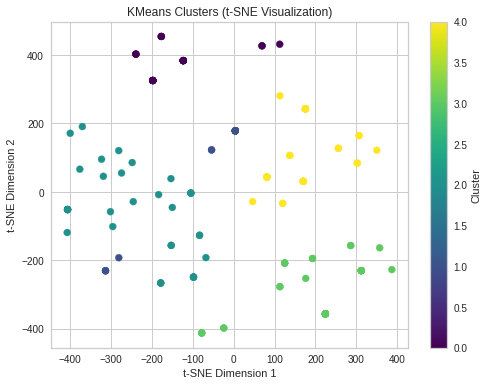

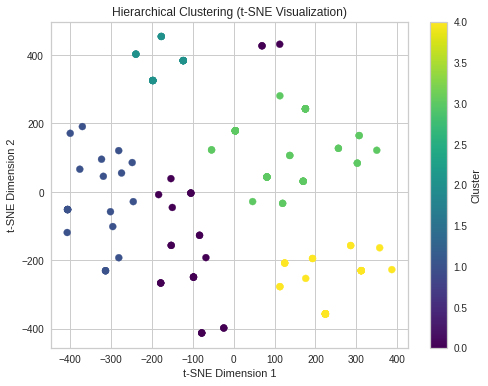

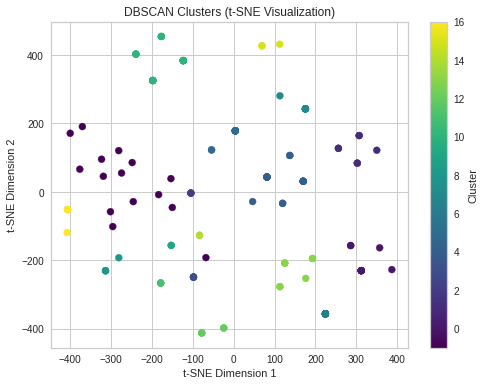

In [120]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_resampled_no_missing)

# Visualize KMeans clusters using t-SNE
kmeans_model = KMeans(n_clusters=best_kmeans_params['n_clusters'], init=best_kmeans_params['init'], random_state=42)
kmeans_labels = kmeans_model.fit_predict(X_resampled_no_missing)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('KMeans Clusters (t-SNE Visualization)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster')
plt.show()

# Visualize Hierarchical Clustering clusters using t-SNE
hierarchical_model = AgglomerativeClustering(n_clusters=best_hierarchical_params['n_clusters'], linkage=best_hierarchical_params['linkage'])
hierarchical_labels = hierarchical_model.fit_predict(X_resampled_no_missing)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=hierarchical_labels, cmap='viridis')
plt.title('Hierarchical Clustering (t-SNE Visualization)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster')
plt.show()

# Visualize DBSCAN clusters using t-SNE
dbscan_model = DBSCAN(eps=best_dbscan_params['eps'], min_samples=best_dbscan_params['min_samples'])
dbscan_labels = dbscan_model.fit_predict(X_resampled_no_missing)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clusters (t-SNE Visualization)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster')
plt.show()

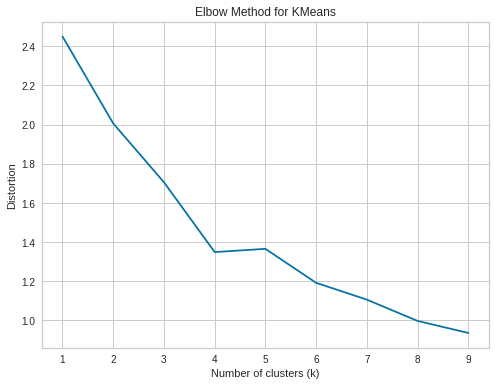

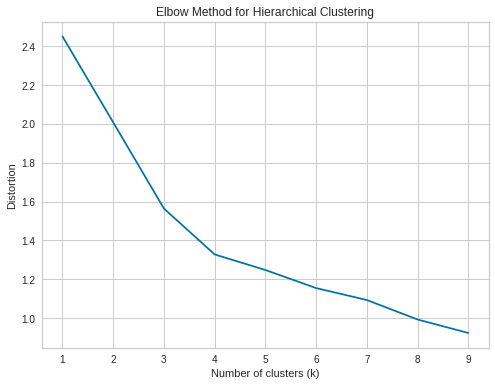

In [126]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import linkage, fcluster
import numpy as np
import matplotlib.pyplot as plt

# Convert X_resampled_no_missing to numeric type
X_resampled_no_missing = X_resampled_no_missing.astype(float)

# Elbow method for KMeans
distortions = []
K = range(1, 10)
for k in K:
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(X_resampled_no_missing)
    distortions.append(sum(np.min(cdist(X_resampled_no_missing, kmeans_model.cluster_centers_, 'euclidean'), axis=1)) / X_resampled_no_missing.shape[0])

plt.figure(figsize=(8, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method for KMeans')
plt.show()

# Elbow method for Hierarchical Clustering
distortions = []
K = range(1, 10)
for k in K:
    Z = linkage(X_resampled_no_missing, method='ward')
    cluster_labels = fcluster(Z, k, criterion='maxclust')
    centroids = []
    for cluster in range(1, k + 1):
        centroids.append(np.mean(X_resampled_no_missing[cluster_labels == cluster], axis=0))
    centroids = np.array(centroids)
    distortions.append(sum(np.min(cdist(X_resampled_no_missing, centroids, 'euclidean'), axis=1)) / X_resampled_no_missing.shape[0])

plt.figure(figsize=(8, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method for Hierarchical Clustering')
plt.show()

In [131]:
from sklearn.metrics import adjusted_mutual_info_score

# Calculate AMI scores for KMeans, Hierarchical Clustering, and DBSCAN
dbscan_model = DBSCAN(eps=best_dbscan_params['eps'], min_samples=best_dbscan_params['min_samples'])
dbscan_labels = dbscan_model.fit_predict(X_resampled_no_missing)

# KMeans
kmeans_model = KMeans(n_clusters=best_kmeans_params['n_clusters'], init=best_kmeans_params['init'], random_state=42)
kmeans_labels = kmeans_model.fit_predict(X_resampled_no_missing)
kmeans_ami = adjusted_mutual_info_score(dbscan_labels, kmeans_labels)
print("AMI score for KMeans (compared to DBSCAN):", kmeans_ami)

# Hierarchical Clustering
hierarchical_model = AgglomerativeClustering(n_clusters=best_hierarchical_params['n_clusters'], linkage=best_hierarchical_params['linkage'])
hierarchical_labels = hierarchical_model.fit_predict(X_resampled_no_missing)
hierarchical_ami = adjusted_mutual_info_score(dbscan_labels, hierarchical_labels)
print("AMI score for Hierarchical Clustering (compared to DBSCAN):", hierarchical_ami)

AMI score for KMeans (compared to DBSCAN): 0.7028125600809387
AMI score for Hierarchical Clustering (compared to DBSCAN): 0.6724129968962033


In [89]:
resampled_data

,Condition_Aging,Condition_Alzheimer Disease 2 Due to Apoe4 Isoform,Condition_Arthroplasty,Condition_Asthma in Children,Condition_Cardiovascular Diseases,Condition_Cardiovascular Risk Factor,Condition_Child Mental Disorders,Condition_Chronic Mesenteric Ischemia,Condition_Cigarette Smoking,"Condition_Cognitive Function, Preclinical",...,176,177,178,KMeans_Cluster,Hierarchical_Cluster,DBSCAN_Cluster,Conditions,Interventions,Age,Sex
0,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,0.000000,0.0,4.0,0.0,Prehypertension|Blood Pressure|Abdominal Obesi...,OTHER: Jump rope exercise intervention,CHILD,FEMALE
1,False,True,False,False,False,False,False,False,False,False,...,0.0,0.0,0.000000,3.0,3.0,1.0,Alzheimer Disease 2 Due to Apoe4 Isoform|Healt...,BEHAVIORAL: Moderate Intensity Aerobic Exercise,OLDER_ADULT,ALL
2,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,0.000000,2.0,0.0,2.0,"Obesity|Heart Failure, Diastolic|Metabolic Syn...",BEHAVIORAL: High intensity exercise|DIETARY_SU...,ADULT,ALL
3,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,0.268828,2.0,1.0,-1.0,Coronary Artery Disease,DRUG: Exercise plus Regadenoson (Lexercise)|DR...,"ADULT, OLDER_ADULT",ALL
4,False,False,False,False,False,False,False,False,False,True,...,0.0,0.0,0.000000,2.0,1.0,-1.0,"Cognitive Function, Preclinical|Chronic Kidney...",BEHAVIORAL: Partially supervised home-based wa...,"ADULT, OLDER_ADULT",ALL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Apply dimensionality reduction techniques to improve feature selection and engineering

In [90]:
# Apply dimensionality reduction techniques
from sklearn.impute import SimpleImputer

numeric_cols = resampled_data.select_dtypes(include=['int64', 'float64']).columns
non_numeric_cols = resampled_data.select_dtypes(exclude=['int64', 'float64']).columns

imputer = SimpleImputer(strategy='mean')
X_numeric = resampled_data[numeric_cols].values
X_numeric_imputed = imputer.fit_transform(X_numeric)

pca = PCA(n_components=0.95)
X_resampled_pca = pca.fit_transform(X_numeric_imputed)

tsne = TSNE(n_components=2, random_state=42)
X_resampled_tsne = tsne.fit_transform(X_numeric_imputed)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_resampled_umap = umap_reducer.fit_transform(X_numeric_imputed)

/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


## Create a new DataFrame with the oversampled data and cluster labels

In [91]:
# Create a new DataFrame with PCA features and cluster labels
resampled_data = pd.DataFrame(X_resampled_pca, columns=[f'feature_{i}' for i in range(X_resampled_pca.shape[1])])

# Perform DBSCAN clustering on the PCA features
best_dbscan = DBSCAN(eps=best_dbscan_params['eps'], min_samples=best_dbscan_params['min_samples'])
dbscan_labels = best_dbscan.fit_predict(resampled_data)
resampled_data['Cluster'] = dbscan_labels

## Merge resampled_data with necessary columns from merged_data

In [92]:
resampled_data = pd.concat([resampled_data, merged_data[['Conditions', 'Interventions', 'Age', 'Sex']]], axis=1)

## Encoding cluster variables

In [93]:
#Encode the cluster labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(resampled_data['Cluster'])

## Association Rule Mining

In [94]:
def generate_association_rules(data):
    # Check if the expected columns exist
    expected_cols = ['Conditions', 'Interventions', 'Age', 'Sex']
    missing_cols = set(expected_cols) - set(data.columns)

    # Use the existing column names if the expected columns are missing
    col_mapping = {
        'Conditions': data.columns[0] if 'Conditions' in missing_cols else 'Conditions',
        'Interventions': data.columns[1] if 'Interventions' in missing_cols else 'Interventions',
        'Age': data.columns[2] if 'Age' in missing_cols else 'Age',
        'Sex': data.columns[3] if 'Sex' in missing_cols else 'Sex'
    }

    # Convert the data into a transactional format
    transactions = []
    for _, row in data.iterrows():
        transaction = []
        conditions = row[col_mapping['Conditions']]
        interventions = row[col_mapping['Interventions']]
        age = str(row[col_mapping['Age']])  # Convert age to string
        sex = str(row[col_mapping['Sex']])  # Convert sex to string

        # Check if conditions and interventions are strings before splitting
        if isinstance(conditions, str):
            transaction.extend(conditions.split('|'))
        else:
            transaction.append(str(conditions))  # Convert to string and append

        if isinstance(interventions, str):
            transaction.extend(interventions.split('|'))
        else:
            transaction.append(str(interventions))  # Convert to string and append

        transaction.append(age)
        transaction.append(sex)
        transactions.append(transaction)

    # Convert the transactional data to a suitable format for association rule mining
    te = TransactionEncoder()
    te_ary = te.fit_transform(transactions)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    # Mine frequent itemsets and generate association rules
    frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.7)

    # Filter rules based on lift
    filtered_rules = rules[(rules['lift'] >= 0.2) & (rules['confidence'] >= 0.2)]

    print("Filtered Association Rules:\n")
    for _, row in filtered_rules.iterrows():
        antecedents = list(row['antecedents'])
        consequents = list(row['consequents'])

        print(f"Rule: {', '.join(antecedents)} --> {', '.join(consequents)}")
        print(f"Support: {row['support']:.2f}, Confidence: {row['confidence']:.2f}, Lift: {row['lift']:.2f}")

        # Interpret the rule and provide examples of personalized exercise recommendations
        if 'Obesity' in antecedents:
            print("Interpretation: This rule suggests that users with obesity prefer or are recommended certain exercise interventions.")
            print("Example Recommendation: For users with obesity, we can recommend low-impact cardio exercises like walking or swimming, combined with strength training to build muscle and increase metabolism.")
        elif 'Diabetes' in antecedents:
            print("Interpretation: This rule indicates a relationship between diabetes and specific exercise preferences or interventions.")
            print("Example Recommendation: For users with diabetes, we can recommend moderate-intensity aerobic exercises like cycling or jogging, along with resistance training to improve insulin sensitivity and glucose control.")

        print("\n")
        
        # Mine frequent itemsets and generate association rules
        frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)

        rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.7)

    # Print the unfiltered rules
    print("Unfiltered Association Rules:")
    print(rules)

    # Filter rules based on lift
    filtered_rules = rules[(rules['lift'] >= 1.2) & (rules['confidence'] >= 0.8)]

    return filtered_rules

## Classification

In [95]:
from sklearn.preprocessing import FunctionTransformer

def perform_classification(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert X_train to a DataFrame
    X_train = pd.DataFrame(X_train)

    # Identify columns with non-numerical values
    non_numeric_columns = X_train.select_dtypes(include=['object']).columns.tolist()

    # Encode categorical features
    if non_numeric_columns:
        categorical_transformer = OneHotEncoder(handle_unknown='ignore')
        preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, non_numeric_columns)])
    else:
        preprocessor = ColumnTransformer(transformers=[('numeric', FunctionTransformer(), X_train.columns)])

    # Fit the preprocessor on the training data
    preprocessor.fit(X_train)

    # Create a pipeline with preprocessing and the classifier
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])

    # Define the parameter grid for GridSearchCV
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 5, 10],
        'classifier__min_samples_split': [2, 5, 10]
    }

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, error_score='raise')
    grid_search.fit(X_train, y_train)

    # Get the best model from grid search
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the test set
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')

    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")

    return best_model, preprocessor

In [96]:
# Perform classification and obtain the best model and preprocessor
classification_model, preprocessor = perform_classification(X_resampled_pca, y_encoded)

/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Accuracy: 0.978
F1-Score: 0.885
Precision: 0.872
Recall: 0.923


/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Integration with the Exercise Habit App

In [97]:
def generate_personalized_recommendations(user_data, classification_model, preprocessor):
    # Get the column names from the fitted preprocessor
    feature_names = preprocessor.transformers_[0][2]
    
    # Check if any columns are missing in user_data
    missing_cols = set(feature_names) - set(user_data.columns)
    if missing_cols:
        # Fill missing columns with NaN or a suitable value
        for col in missing_cols:
            user_data[col] = np.nan
    
    # Check if there are any extra columns in user_data
    extra_cols = set(user_data.columns) - set(feature_names)
    if extra_cols:
        # Drop extra columns from user_data
        user_data = user_data.drop(list(extra_cols), axis=1)
    
    # Reorder the columns in user_data to match the order of feature_names
    user_data = user_data[feature_names]
    
    # Perform feature engineering on user_data
    user_features = preprocessor.transform(user_data)
    
    # Convert user_features to a DataFrame
    user_features = pd.DataFrame(user_features, columns=feature_names)
    
    # Check if user_features has only one row
    if user_features.shape[0] == 1:
        # If there is only one row, skip VarianceThreshold and selector
        user_features_selected = user_features
    else:
        # Create a new VarianceThreshold object and fit it on user_features
        new_variance_threshold = VarianceThreshold()
        new_variance_threshold.fit(user_features)
        
        # Apply the new VarianceThreshold and the selector on user_features
        user_features_selected = new_variance_threshold.transform(user_features)
        
    
    # Impute missing values in user_features_selected
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    user_features_selected = imputer.fit_transform(user_features_selected)
    
    # Convert user_features_selected to a DataFrame
    user_features_selected = pd.DataFrame(user_features_selected, columns=feature_names)
    
    # Create a new ColumnTransformer for user_features_selected
    new_preprocessor = ColumnTransformer(transformers=[('numeric', FunctionTransformer(), user_features_selected.columns)])
    
    # Fit the new ColumnTransformer on user_features_selected
    new_preprocessor.fit(user_features_selected)
    
    # Transform user_features_selected using the new ColumnTransformer
    user_features_selected_transformed = new_preprocessor.transform(user_features_selected)
    
    # Use the transformed user_features_selected_transformed with the classifier
    user_cluster = classification_model.predict(user_features_selected_transformed)[0]
    
    recommendations = []
    
    if user_cluster == 0:
        recommendations.append("Focus on low-impact exercises like walking or yoga, considering your age and any comorbidities.")
        recommendations.append("Incorporate strength training exercises to maintain muscle mass and bone density.")
        recommendations.append("Include balance and stability exercises to reduce the risk of falls.")
    elif user_cluster == 1:
        recommendations.append("Engage in moderate-intensity cardiovascular exercises like cycling or swimming, considering your weekly goal.")
        recommendations.append("Include strength training exercises to improve overall fitness and manage weight.")
        recommendations.append("Consider stress-reducing activities like meditation or deep breathing exercises.")
    elif user_cluster == 2:
        recommendations.append("Engage in activities that promote cognitive function, such as puzzles or memory games.")
        recommendations.append("Include breathing exercises and activities that improve lung capacity.")
        recommendations.append("Participate in group exercise classes or social activities to maintain engagement and motivation.")
    
    # Generate association rules
    association_rules_data = generate_association_rules(user_data)

    # Iterate over the association rules
    for rule in association_rules_data.itertuples(index=False):
        antecedents = list(rule.antecedents)
        consequents = list(rule.consequents)
        if all(item in user_data.values for item in antecedents):
            recommendations.append(f"Based on your profile, we recommend: {', '.join(consequents)}")
    
    return recommendations

In [98]:
# Example usage
user_data = pd.DataFrame({
    'Age': ['ADULT'],
    'Sex': ['FEMALE'],
    'Conditions': ['Diabetes'],
    'Interventions': ['Exercise intervention for Obesity']
})

personalized_recommendations = generate_personalized_recommendations(
    user_data,
    classification_model,
    preprocessor,
)

print("Personalized Exercise Recommendations:")
for recommendation in personalized_recommendations:
    print(f"- {recommendation}")

Filtered Association Rules:

Unfiltered Association Rules:
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []
Personalized Exercise Recommendations:
